Going through pytorch tutorial commenting (almost) everything

In [2]:
import torch
from torch import nn #neural network
from torch.utils.data import DataLoader #data loader for dataset
from torchvision import datasets # built in datasets
from torchvision.transforms import ToTensor # transforms the image to tensor (tensor is a multi-dimensional matrix)

c:\Programs\Anaconda\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Programs\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
# FashionMNIST dataset is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples

training_data = datasets.FashionMNIST(
    root="data", #root is the location where the data is stored
    train=True, #true for training, false for testing
    download=True, #true to download, false if already downloaded
    transform=ToTensor() 
)

test_data = datasets.FashionMNIST (
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
#if we would like to load data from csv file, we can use pandas library
#training_data = pd.read_csv('data.csv') transform=ToTensor() is not needed since it is already in tensor(matrix) form



100%|██████████| 26421880/26421880 [00:01<00:00, 17916734.15it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 1867249.13it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 14933567.45it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [14]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size) #dataloader is used to shuffle and batch the data, shuffling for randomness
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [28]:
for X,y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape) #N samles, C channels(gray scale), H height, W width
    print("Shape of y: ", y.shape, y.dtype) #y is the label, so shape of y = N = batch size
    break #break to stop the loop after one iteration

test_data.targets.unique() #labels of the test data


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using {device} device') 

Using cpu device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self): #initializing the neural network
        super().__init__() #super() is used to call the parent class constructor
        self.flatten = nn.Flatten() #flatten the tensor to 1D 
        self.linear_relu_stack = nn.Sequential ( 
            nn.Linear(28*28, 512), #input layer
            nn.ReLU(), #activation function
            nn.Linear(512, 512), #hidden layer  512 in, 512 out
            nn.ReLU(),
            nn.Linear(512, 10) #output layer with 10 classes, 512 in, 10 out, linear activation function because we are using cross entropy loss
        )
        
    def forward(self, x): #forward pass, x is the input logits(log-odds) are the output
        x = self.flatten(x)
        logits = self.linear_relu_stack(x) 
        return logits

In [33]:
model=NeuralNetwork().to(device) # to(device) is used to move the model to the device (cpu or gpu)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [34]:
loss_fn = nn.CrossEntropyLoss() #negative log likelihood with softmax built in
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #stochastic gradient descent optimizer



In [35]:
def train(dataloader, model, loss_fn, optimizer): 
    size = len(dataloader.dataset) #size of the dataset (number of samples)
    model.train() #set the model to training mode
    for batch, (X, y) in enumerate(dataloader): #iterate over the batches
        X, y = X.to(device), y.to(device)
        
        pred = model(X) #make predictions
        loss = loss_fn(pred, y) #calculate the loss and use it in backpropagation
        
        loss.backward() #backpropagate the loss
        optimizer.step() #update the parameters
        optimizer.zero_grad() #reset the gradients to zero to address the accumulation of gradients
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X) #loss.item() is used to get the scalar value held in the loss
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) #size of the dataset
    num_batches = len(dataloader) #number of batches
    model.eval()
    test_loss, correct = 0, 0 
    with torch.no_grad(): #no need to calculate gradients during testing, 'with' means that the block of code is executed without calculating the gradients
    
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            loss = loss_fn(pred, y) #current loss
            test_loss += loss.item() #overall loss to report
            
            correctly_predicted = (pred.argmax(1) == y).type(torch.float).sum().item() #number of correctly predicted samples true/false => 1.0/0.0 => sum of 1s => extract the scalar value from the tensor
            correct += correctly_predicted #overall number of correctly predicted samples
            
    test_loss /= num_batches #average loss across all batches
    correct /= size #accuracy
        
    print (f"Test accuracy: {correct}, Average loss: {test_loss}")

In [38]:
epochs = 10
for i in range(epochs):
    print (f"Epoch {i}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print (f"Done")

Epoch 0
loss: 2.293887  [   64/60000]
loss: 2.284237  [ 6464/60000]
loss: 2.265129  [12864/60000]
loss: 2.268166  [19264/60000]
loss: 2.242955  [25664/60000]
loss: 2.216816  [32064/60000]
loss: 2.222272  [38464/60000]
loss: 2.183035  [44864/60000]
loss: 2.177886  [51264/60000]
loss: 2.155577  [57664/60000]
Test accuracy: 0.447, Average loss: 2.1467758849927576
Done
Epoch 1
loss: 2.157333  [   64/60000]
loss: 2.148030  [ 6464/60000]
loss: 2.085177  [12864/60000]
loss: 2.108140  [19264/60000]
loss: 2.060771  [25664/60000]
loss: 1.999161  [32064/60000]
loss: 2.027446  [38464/60000]
loss: 1.940122  [44864/60000]
loss: 1.941845  [51264/60000]
loss: 1.885275  [57664/60000]
Test accuracy: 0.5939, Average loss: 1.8767663825089764
Done
Epoch 2
loss: 1.913813  [   64/60000]
loss: 1.882994  [ 6464/60000]
loss: 1.756091  [12864/60000]
loss: 1.802019  [19264/60000]
loss: 1.699396  [25664/60000]
loss: 1.654137  [32064/60000]
loss: 1.672935  [38464/60000]
loss: 1.564328  [44864/60000]
loss: 1.590086 

In [ ]:
import random
for i in range(20):
    model.eval()
    sample = random.randint(0, len(test_data)) #randomly select a sample from the test data
    X, y = test_data[sample][0], test_data[sample][1] 
    with torch.no_grad():
        pred = model(X) 
        predicted, actual = pred[0].argmax(0), y 
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "9"
Predicted: "4", Actual: "4"
Predicted: "4", Actual: "6"
Predicted: "2", Actual: "6"
Predicted: "0", Actual: "0"
Predicted: "9", Actual: "9"
Predicted: "3", Actual: "3"
Predicted: "1", Actual: "1"
Predicted: "8", Actual: "8"
Predicted: "0", Actual: "0"
Predicted: "3", Actual: "3"
Predicted: "4", Actual: "4"
Predicted: "2", Actual: "2"
Predicted: "0", Actual: "0"
Predicted: "1", Actual: "1"
Predicted: "3", Actual: "3"
Predicted: "7", Actual: "7"
Predicted: "7", Actual: "9"
Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"


In [53]:
torch.save(model.state_dict(), "model.pth") # to save 

model = NeuralNetwork().to(device)                                # to load 
model.load_state_dict(torch.load("model.pth", weights_only=True)) # to load

C:\Users\Mykyta\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

2. Tensors

In [62]:
#reimport so can run separately
import torch
import numpy as np

data = [[1, 2],[3, 4]] #vanilla python  matrix (list of lists)
x_data = torch.tensor(data) #convert list to tensor
x_data



tensor([[1, 2],
        [3, 4]])

In [64]:
np_array = np.array(data) 
x_np = torch.from_numpy(np_array) # torch.tensor() works, but torch.from_numpy() is more efficient = shares memory with numpy array
x_np

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

In [72]:
x_ones = torch.ones_like(x_data) #tensor with same shape as x_data with all ones
print(x_ones)
x_rands = torch.rand_like(x_data, dtype=torch.float) #same but random values
print(x_rands)

tensor([[1, 1],
        [1, 1]])
tensor([[0.5054, 0.3623],
        [0.6883, 0.5129]])


In [76]:
shape = (2,3) 
rand_tensor = torch.rand(shape) #random tensor with shape
print(rand_tensor)

tensor([[0.3875, 0.4103, 0.5404],
        [0.1164, 0.3703, 0.6645]])


In [83]:
print(f'Shape of rand_tensor: {rand_tensor.shape}')
print(f'Datatype of rand_tensor: {rand_tensor.dtype}')
print(f'Device use for rand_tensor: {rand_tensor.device}')

Shape of rand_tensor: torch.Size([2, 3])
Datatype of rand_tensor: torch.float32
Device use for rand_tensor: cpu


In [3]:
# same as NumPy: tensor[row][column] or tensor[row, column] <-- second is more efficient

tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}") # ... - all elements in all dimensions, : - all elements in that dimension
tensor[:,1] = 0  #set the second column to 0
print(tensor)



First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [5]:
t1 = torch.cat([tensor, tensor, tensor], dim=0) #concatenate, 0 - along rows(vertically), 1 - along columns(horizontally)
print(t1)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [8]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T) #same as above, matmul = matrix multiplication

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3) #same as above, but the result is stored in y3, so like y3 = tensor @ tensor.T or y3 = tensor.matmul(tensor.T)



tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [11]:
#element-wise multiplication, same result in this cases
z1 = tensor * tensor
z2 = tensor.mul(tensor) 
z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [13]:
agg = tensor.sum() #sum of all elements
print(agg)
num_value=agg.item()
print(num_value)

tensor(12.)
12.0


In [14]:
tensor.add_(5) #in-place addition, tensor is modified, saves memory, but can be dangerous (no history of operations)
print(tensor)


tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [22]:
#numpy array to tensor and vice versa
#bridge between torch and numpy
#changing one will change the other

import numpy as np
t = torch.ones(5)
print(f'tensor: {t}')
n = t.numpy()
print(f'numpy: {n}')

t.add_(1) #changed tensor, numpy changed
print(f'tensor: {t}')
print(f'numpy: {n}')

np.add(n, 1, out=n) #changed numpy, tensor changed
print(f'tensor: {t}')
print(f'numpy: {n}')


tensor: tensor([1., 1., 1., 1., 1.])
numpy: [1. 1. 1. 1. 1.]
tensor: tensor([2., 2., 2., 2., 2.])
numpy: [2. 2. 2. 2. 2.]
tensor: tensor([3., 3., 3., 3., 3.])
numpy: [3. 3. 3. 3. 3.]


3.Datasets & DataLoaders

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [3]:
training_data = datasets.FashionMNIST (
    root='data',
    train = True,
    download = True,
    transform = ToTensor()
    
)

test_data = datasets.FashionMNIST (
    root='data',
    train = False,
    download = True,
    transform = ToTensor()
    
)

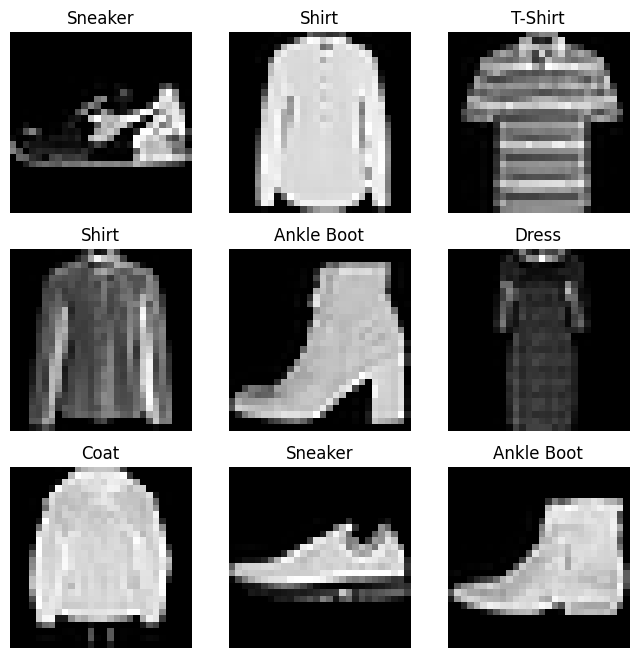

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range (1,10):
    sample_idx=torch.randint(len(training_data),size=(1,)).item() #randomly select a sample from the training data, 
    #size=(1,) means that the size of the tensor is 1 .item() is used to extract the scalar value from the tensor
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off") #remove axis
    plt.imshow(img.squeeze(), cmap="gray")  #squeeze is used to remove the channel dimension
    # cmap="gray" is used to display the image in grayscale
plt.show()   
    
    

Custom dataset

In [23]:
import os
import pandas as pd
from torchvision.io import read_image
#custom dataset with directory of images and csv file of file names and labels
class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None): #initialize the dataset 
        self.img_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels) #return the number of samples in the dataset
    def __getitem__(self, idx): #get the sample at the index idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) #directory + image name, assume filenames are in column 0 in the separate csv file
        image = read_image(img_path) #read_image from torchvision.io
        label = self.img_labels.iloc[idx, 1] #assume labels are in column 1 in the separate csv file
        if self.transform: # if not None
            image = self.transform(image) #transform the image
        if self.target_transform:
            label = self.target_transform(label) #transform the label
        return image, label  